<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/9.%20Convolutional%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Convolutional Neural Networks

> A Convolutional Neural Networks is a NN which has at least one layer (``tf.nn.conv2d`` in ``tf``) that does a convolution between its input $f$ and a configurable kernel $k$, $(f*k)$. 

Convolutional Neural Networks have been some of the most influential innovations in the field of **computer vision** in the last years. 

When considering the analysis of an image with a computer we must define a computational representation of an image. To this end, images are represented as $n \times m \times 3$ array of numbers, called **pixels**.
The 3 refers to RGB values and $n, m$ refers to the height and width of the image in pixels. Each number in this array is given a value from 0 to 255 which describes the pixel intensity at that point.  These numbers are the only inputs available to the computer. 

**What is to classify an image?** The idea is that you give the computer this array of numbers and it must output numbers that describe the probability of the image being a certain class.

Of course, this kind of image representation is suited to be classified by a classical neural network composed of **dense layers**, but this approach has **several limitations**.

The first one is that large images with a high number of pixels will need from **extremely large networks** to be analyzed. If an image has $256 \times 256 = 65,536$ pixels, the first layer of a classical neural network needs to have $65,536 \times 65,536 = 4,294,967,296$ different weights to consider all pixel interactions. Even in the case that this number of weights could be stored in the available memory, learning these weights would be very time consuming. But there are better alternatives.

One possible solution for this problem is to consider **local receptive fields (LRF)** (an inspiration that comes from neuroscience). A local receptive field is a standard MLP with a local view of the image: its input is a submatrix $M \times M$ of the original $N \times N$, where $M << N$.

Using LRF is like decomposing the problem of image analysis in a set of local *experts* that are specialized in certain parts of the image. The outcome of these specialists can be integrated at a high level of the model.

> Could you propose a problem where a LRF architecture could be the best option?

Let's suppose we are dealing with a common task: object detection.

In the most general setting, images represent the field of view of a camera (robot, autonomous car, person, etc.). Hence, we cannot assume any prior information about the presence of the object of interest on the image (i.e. any prior information about its scale, point of view, etc. or even its localization with respect to image coordinates). 

> An object may appear at any image coordinates!

In this case LRF are not suited for this task because in order to learn a detector we should provide the model with a lot of examples in order to consider all possible object localitions!

But, what about sharing LRF weights?

Natural images are not a random combination of values in a $N \times M$ array, but present **strong correlations** at different levels. 

At the most basic, it is evident that the **value of a pixel** is not independent of the values of its neighboring pixels. 

Moreover, natural images present another interesting property: **location invariance**. That means that visual structures, such as a cat or a dog, can be present on any place of the image at any scale. Image location is not important, what is important for attaching a meaning to an image are the **relative positions of geometric and photometric structures**. 

All this considerations leaded, partially inspired by biological models, to the proposal of a very special kind of layers: those based on **convolutions**. 

> A convolution is a mathematical operation that combines two input images to form a third one. One of the input images is the image we want to process. The other one, that is smaller, is called the kernel. 

Let's suppose that our kernel is this one:

$$ Kernel = \left( \begin{array}{rrr} 0 & -1 & 0 \\ -1 & 5 & -1 \\  0 & -1 & 0 \end{array} \right)$$

The output of image convolution is calculated as follows:

- Flip the kernel both horizontally and vertically. As our selected kernel is symmetric, the flipped kernel is equal to the original.
- Put the first element of the kernel at every element of the image matrix. Multiply each element of the kernel with its corresponding element of the image matrix (the one which is overlapped with it). 
- Sum up all product outputs and put the result at the same position in the output matrix as the center of kernel in image matrix.


## What is a convolution?

Mathematically, given a convolution kernel $K$ represented by a $(M \times N)$ array, the convolution of an image $I$ with $K$ is:

$$
output(x,y) = (I \otimes K)(x,y) = \sum_{m=0}^{M-1} \sum_{n=1}^{N-1} K(m,n) I(x-n, y-m)
$$

The output of image convolution is another image that might represent some kind of information that was present in the image in a very subtle way. For example, the kernel we have used is called an **edge detector** because it highlights the edges of visual structures and attenuates smooth regions. 

> Demo: http://setosa.io/ev/image-kernels/

In **convolutional neural networks** the values of the kernel matrix are **free parameters** that must be learned to perform the optimal information extraction in order to classify the image. 

Convolutions are linear operators and because of this the application of successive convolutions can always be represented by a single convolution.

$$
((I \otimes K_1) \otimes K_2) = (I \otimes (K_1 \otimes K_2))
$$

But if we apply a non linear activation function after each convolution the application of successive convolution operators makes sense and results in a powerful image feature structure. 

sample image shape: (256, 209, 4)


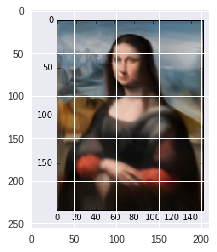

In [3]:
import tensorflow as tf
import numpy as np
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

sample_image = imread("https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/images/result.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: "+ str(sample_image.shape))

def show(image):
    image = np.squeeze(image.astype("uint8"))
    plt.imshow(image, cmap="gray")

show(sample_image)

In [4]:
sample_image= sample_image[:,:,:-1]
sample_image.shape

(256, 209, 3)

#### Example

Let's build a convolution filter that blurs the image using `tf.nn.depthwise_conv2d`. This function treats each channel separately. If not, it would be a 3D convolution!

Given an input tensor of shape ``[batch, in_height, in_width, in_channels]`` and a filter tensor of shape ``[filter_height, filter_width, in_channels, channel_multiplier]`` containing ``in_channels`` convolutional filters of depth 1, ``depthwise_conv2d`` applies a different filter to each input channel (expanding from 1 channel to ``channel_multiplier`` channels for each), then concatenates the results together. 

In [5]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 3))
kernel = tf.placeholder(tf.float32, shape=(5, 5, 3))

def conv(x, k):
    k = tf.reshape(k, shape=(5, 5, 3, 1))
    return tf.nn.depthwise_conv2d(x, 
                                  k, 
                                  strides=(1, 1, 1, 1),
                                  padding='SAME')
    
output_image = conv(image, kernel)
kernel_data = np.zeros(shape=(5, 5, 3)).astype(np.float32)
kernel_data[:, :, :] = 1 / 25.0

# move the channel dimension to the first dimension to
# make it easy to see the spacial organization of the kernel
# on the last 2 dimensions with print:
print(np.transpose(kernel_data, (2, 0, 1))) 

[[[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]]


(1, 256, 209, 3)


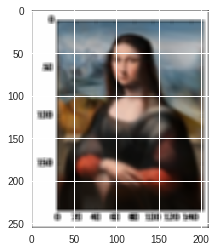

In [6]:
with tf.Session() as sess:
    feed_dict = {image: [sample_image], kernel: kernel_data}
    conv_img = sess.run(output_image, feed_dict=feed_dict)
    print(conv_img.shape)
    show(conv_img[0])

#### Example

``tf.nn.conv2d``: Given an input tensor of shape ``[batch, in_height, in_width, in_channels]`` and a filter / kernel tensor of shape ``[filter_height, filter_width, in_channels, out_channels]``, this op performs the following:

+ Flattens the filter to a 2-D matrix with shape ``[filter_height * filter_width * in_channels, output_channels]``.
+ Extracts image patches from the input tensor to form a virtual tensor of shape ``[batch, out_height, out_width, filter_height * filter_width * in_channels]``.
+ For each patch, right-multiplies the filter matrix and the image patch vector.

In [7]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 3))
kernel = tf.placeholder(tf.float32, shape=(5, 5, 3))

def conv(x, k):
    k = tf.reshape(k, shape=(5, 5, 3, 1))
    return tf.nn.conv2d(x, 
                        k, 
                        strides=(1, 1, 1, 1),
                        padding='SAME')
    
output_image = conv(image, kernel)
kernel_data = np.zeros(shape=(5, 5, 3)).astype(np.float32)
kernel_data[:, :, :] = 1 / 125.0

# move the channel dimension to the first dimension to
# make it easy to see the spacial organization of the kernel
# on the last 2 dimensions with print:
print(np.transpose(kernel_data, (2, 0, 1))) 

[[[0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]]

 [[0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]]

 [[0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]
  [0.008 0.008 0.008 0.008 0.008]]]


(1, 256, 209, 1)


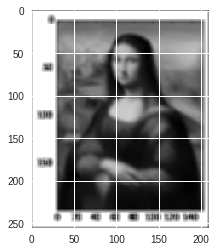

In [8]:
with tf.Session() as sess:
    feed_dict = {image: [sample_image], kernel: kernel_data}
    conv_img = sess.run(output_image, feed_dict=feed_dict)
    print(conv_img.shape)
    show(conv_img[0])

### Exercise

+ What happens if we build a 3x3 kernel with stride 2? What is the size of the output image?


+ When a kernel is overlapped on an image it should be set to fit within the bounds of the image. Filling the missing area of the image is known as *padding* the image. The padding parameter must be ``SAME``  if we want the convolution output to be the same size as the input, and ``VALID`` if we want only the useful part of the output.   
What happens if we change the padding to 'VALID'?

In [0]:
# your code here



## Convolutional Neural Netwoks

The kernel weights can be learn from examples if we define a loss function.

> CNN are composed of repetitive blocks of neurons that are applied across
space (for images) or time (for audio signals).

> For images, these blocks of neurons can be interpreted as
2D convolutional kernels, repeatedly applied over each
patch of the image.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/conv.png?raw=1" alt="https://community.arm.com/cfs-file/__key/communityserver-blogs-components-weblogfiles/00-00-00-20-66/4786.conv.png" style="width: 500px;"/>


> For speech, they can be seen as the 1D convolutional
kernels applied across time-windows.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/spectrogram.png?raw=1" alt="" style="width: 500px;"/>


At training time, the weights for these repeated blocks are
'shared', i.e. the weight gradients learned over various
image patches are averaged.

CNN where originally proposed in early 90's by Y.LeCun:

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/conv2.png?raw=1" alt="" style="width: 700px;"/>


LeNet architecture used one additional ingredient: **max pooling**. Pooling is a way of sub-sampling, i.e. reducing the dimension of the input. It is usually done after convolutional layers. 

It is also useful since it provides a form of translation invariance. 

## MNIST Convolutional Network 

A simple CNN architecture cambines a convolutional layer (``tf.nn.conv2d``), a non-linear activation function (``tf.nn.relu``), a pooling layer (``tf.nn.max_pool``) and a fully connected layer (``tf.matmul``). 

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/maxpool.jpeg?raw=1" alt="" style="width: 400px;"/>
<center>
Max Pooling. Source: http://cs231n.github.io/convolutional-networks/
</center>


The ``tf`` input pipeline is designed to work with multiple images in a batch: `` [image_batch_size, image_height, image_width, image_channels] ``. 

In [9]:
# Adapted notebook from Author: Aymeric Damien
# Project: https://github.com/aymericdamien/TensorFlow-Examples/

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tenso

In [0]:
import tensorflow as tf

# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 20

In [0]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [0]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

The parameter ``strides`` causes a kernel to skip over pixels of an image and not to include them in the output. 

Strides are a way to adjust the dimensionality of input tensors (to reduce processing power). This allows the design of CNN with small kernels but getting information from large parts of the input. 

In [0]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1, k=2)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)

    # Convolution Layer
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [15]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])), 
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])), 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                      (logits= pred, labels= y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
# Initializing the variables
init = tf.global_variables_initializer()

In [20]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, 
                 feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, 
                           feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, 
                            feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print("Iter ", str(step*batch_size),
                  "| Minibatch Loss= {:.6f}".format(loss)  , 
                  "| Training Accuracy= {:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", 
          sess.run(accuracy, 
                   feed_dict={x: mnist.test.images[:256], 
                   y: mnist.test.labels[:256], 
                   keep_prob: 1.}))

Iter  2560 | Minibatch Loss= 13193.554688 | Training Accuracy= 0.39062
Iter  5120 | Minibatch Loss= 6030.086914 | Training Accuracy= 0.66406
Iter  7680 | Minibatch Loss= 5493.271484 | Training Accuracy= 0.67188
Iter  10240 | Minibatch Loss= 3282.389648 | Training Accuracy= 0.82031
Iter  12800 | Minibatch Loss= 3090.636230 | Training Accuracy= 0.78906
Iter  15360 | Minibatch Loss= 3579.398193 | Training Accuracy= 0.81250
Iter  17920 | Minibatch Loss= 2695.186279 | Training Accuracy= 0.79688
Iter  20480 | Minibatch Loss= 2598.989990 | Training Accuracy= 0.81250
Iter  23040 | Minibatch Loss= 1942.210449 | Training Accuracy= 0.86719
Iter  25600 | Minibatch Loss= 1753.649658 | Training Accuracy= 0.88281
Iter  28160 | Minibatch Loss= 1287.926147 | Training Accuracy= 0.89062
Iter  30720 | Minibatch Loss= 2092.691406 | Training Accuracy= 0.84375
Iter  33280 | Minibatch Loss= 968.024475 | Training Accuracy= 0.89062
Iter  35840 | Minibatch Loss= 1115.352417 | Training Accuracy= 0.89844
Iter  384

Some CNN architectures use **normalization** layers. 

For example, ``tf.nn.local_response_normalization`` is a function which shapes the output based on a summation operation in the following way: within a given vector, each component is divided by the weighted, squared sum of inputs within a depth radius. 

> In neurobiology, there is a concept called “lateral inhibition”. This refers to the capacity of an excited neuron to subdue its neighbors.


In fact, after a convolutional layer there are two kinds of non linear functions that are usually applied: non-linear activation functions such as sigmoids or **ReLU and pooling**. Pooling layers are used with the purpose to progressively reduce the spatial size of the image to achieve scale invariance.The most common layer is the maxpool layer. Basically a maxpool of $2 \times 2$ causes a filter of 2 by 2 to traverse over the entire input array and pick the largest element from the window to be included in the next representation map. Pooling can also be implemented by using other criteria, such as averaging instead of taking the max element. 

A convolutional neural network is a neural network that is build by using several convolutional layers, each one formed by the concatenation of three different operators: **convolutions, non-linear activation and pooling**. This kind of networks are able of extracting powerful image descriptors when applied in sequence. The power of the method has been credited to the fact that these descriptors can be seen as hierarchical features that are suited to optimally represent visual structures in natural images. The last layers of a convolutional neural network are classical dense layers, which are connected to a classification or regression loss function.

Finally, it is interesting to point out that convolutional layers are much **lighter**, in terms of number of weights, than fully connected layers, but more computationally demanding (The number of weights we must learn for a $(M \times N)$ convolution kernel is only $(M \times N)$, which is independent of the size of the image). 

In some sense, **convolutional layers trade weights for computation when extracting information**. 


## Visualization of learned kernels.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/weights.jpeg?raw=1" alt="" style="width: 400px;"/>
<center>
Convolution kernels from the first AlexNet layer. <br>
    
Source: http://cs231n.github.io/convolutional-networks/
</center>

## Exercise:

**VGGNet**. The runner-up in ILSVRC 2014 was the network from Karen Simonyan and Andrew Zisserman that became known as the VGGNet. Its main contribution was in showing that the depth of the network is a critical component for good performance. Their final best network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs $3 \times 3$ convolutions and $2 \times 2$ pooling from the beginning to the end. 

The architecture is:

+ INPUT: [224x224x3] 
+ CONV3-64: [224x224x64]  
+ CONV3-64: [224x224x64]  
+ POOL2: [112x112x64]  
+ CONV3-128: [112x112x128]  
+ CONV3-128: [112x112x128]  
+ POOL2: [56x56x128]  
+ CONV3-256: [56x56x256]  
+ CONV3-256: [56x56x256]  
+ CONV3-256: [56x56x256]  
+ POOL2: [28x28x256]  
+ CONV3-512: [28x28x512]  
+ CONV3-512: [28x28x512]  
+ CONV3-512: [28x28x512]  
+ POOL2: [14x14x512]  
+ CONV3-512: [14x14x512]  
+ CONV3-512: [14x14x512]  
+ CONV3-512: [14x14x512]  
+ POOL2: [7x7x512]  
+ FC1: [1x1x4096]  
+ FC2: [1x1x4096]  
+ FC3: [1x1x1000]  

Which is the approximate number of parameters of this network? Which is the heaviest layer?

In [0]:
# Your code here

## Smile Detection using Convolutional Neural Networks

In [0]:
# Adapted from Kyle McDonald
# Project: https://github.com/kylemcdonald/SmileCNN

In [22]:
!curl -L -O https://github.com/hromi/SMILEsmileD/archive/master.zip
!unzip -q master.zip
!rm master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   122    0   122    0     0    762      0 --:--:-- --:--:-- --:--:--   762
100 39.6M    0 39.6M    0     0  17.2M      0 --:--:--  0:00:02 --:--:-- 19.5M


In [0]:
#util and imports
import os
import fnmatch

def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined
                
import numpy as np
import math

def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

# should work for 1d and 2d images, assumes images are square but can be overriden
def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

import numpy as np
from skimage.measure import block_reduce

def crop_and_resize(img, target_size=32, zoom=1):
    small_side = int(np.min(img.shape) * zoom)
    reduce_factor = small_side / target_size
    crop_size = target_size * reduce_factor
    mid = np.array(img.shape) / 2
    half_crop = crop_size / 2
    center = img[mid[0]-half_crop:mid[0]+half_crop,
    	mid[1]-half_crop:mid[1]+half_crop]
    return block_reduce(center, (reduce_factor, reduce_factor), np.mean)

from io import BytesIO
import numpy as np
import PIL.Image
import IPython.display
import shutil

def show_array(a, fmt='png', filename=None):
    a = np.squeeze(a)
    a = np.uint8(np.clip(a, 0, 255))
    image_data = BytesIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

In [24]:
negative_paths = list(list_all_files('SMILEsmileD-master/SMILEs/negatives/negatives7/', ['.jpg']))
print('loaded', len(negative_paths), 'negative examples')
positive_paths = list(list_all_files('SMILEsmileD-master/SMILEs/positives/positives7/', ['.jpg']))
print('loaded', len(positive_paths), 'positive examples')
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


In [25]:
#!pip install -U scikit-image

    100% |████████████████████████████████| 26.3MB 1.4MB/s 
    100% |████████████████████████████████| 2.0MB 11.8MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


In [26]:
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_grey=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        X.append(img)
        y.append(label)
    return np.asarray(X), np.asarray(y)

%time X, y = examples_to_dataset(examples)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


CPU times: user 8.83 s, sys: 540 ms, total: 9.37 s
Wall time: 9.38 s


In [27]:
X = X.astype(np.float32) / 255.
y = y.astype(np.int32)
print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)

float32 0.0 1.0 (13165, 32, 32)
int32 0 1 (13165,)


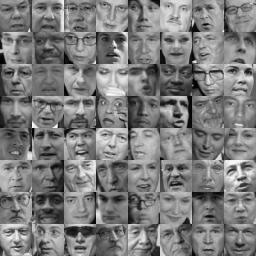

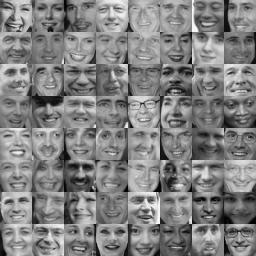

In [28]:
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

In [0]:
X = np.expand_dims(X, axis=-1)
np.save('X.npy', X)
np.save('y.npy', y)

In [30]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

# load the data
X = np.load('X.npy')
y = np.load('y.npy')

# convert classes to vector
nb_classes = 2
y = np_utils.to_categorical(y, nb_classes).astype(np.float32)

# shuffle all the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)

float32 0.0 1.0 (13165, 32, 32, 1)
float32 0.0 1.0 (13165, 2)


Using TensorFlow backend.


In [31]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [32]:
validation_split = 0.10
model.fit(X, y, batch_size=128, class_weight=class_weight, epochs=5, verbose=1, validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 11848 samples, validate on 1317 samples
Epoch 1/5
11848/11848 [==============================] - 33s 3ms/step - loss: 0.4723 - acc: 0.7698 - val_loss: 0.3584 - val_acc: 0.8466
Epoch 2/5
11848/11848 [==============================] - 33s 3ms/step - loss: 0.3376 - acc: 0.8563 - val_loss: 0.3120 - val_acc: 0.8770
Epoch 3/5
11848/11848 [==============================] - 33s 3ms/step - loss: 0.3061 - acc: 0.8809 - val_loss: 0.2787 - val_acc: 0.8853
Epoch 4/5
11848/11848 [==============================] - 33s 3ms/step - loss: 0.2876 - acc: 0.8861 - val_loss: 0.2611 - val_acc: 0.8937
Epoch 5/5
11848/11848 [==============================] - 32s 3ms/step - loss: 0.2678 - acc: 0.8985 - val_loss: 0.2412 - val_acc: 0.9104


In [0]:
open('model.json', 'w').write(model.to_json())
model.save_weights('weights.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


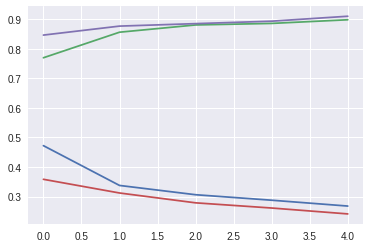

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.model.history.history['loss'])
plt.plot(model.model.history.history['acc'])
plt.plot(model.model.history.history['val_loss'])
plt.plot(model.model.history.history['val_acc'])
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print(roc_auc_score(y[-n_validation:], y_predicted))

0.957985626213427
